# Landsat LST Sharpening Example

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.lst
#import openet.core

In [2]:
# ee.Authenticate()
ee.Initialize()

In [3]:
# landsat_id = 'LC08_044033_20170918'  # Cloudy, some clear areas over northern CV
# # landsat_id = 'LC08_042034_20180705'  # Clear

# landsat_img = ee.Image(f'LANDSAT/LC09/C02/T1_L2/{landsat_id}')
# region = landsat_img.geometry().buffer(-60000)

# Checking for masking over Lake Tahoe
landsat_id = 'LC09_043033_20240704'  
region = ee.Geometry.BBox(-120.03, 38.91, -119.70, 39.03)
landsat_img = ee.Image(f'LANDSAT/LC09/C02/T1_L2/{landsat_id}')


In [4]:
viridis = ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725']
image_size = 768

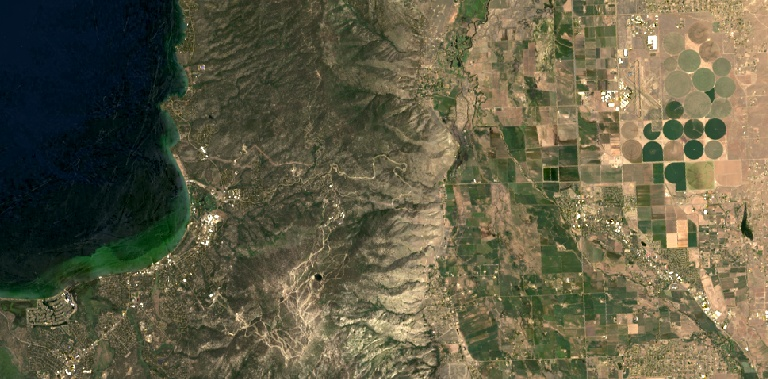

In [5]:
image_url = (
    landsat_img.select([3, 2, 1]).multiply(0.0000275).add(-0.2)
    .getThumbURL({'min': 0.0, 'max': 0.25, 'gamma': 1.25, 'dimensions':image_size, 'region': region})
)
Image(url=image_url, embed=True, format='png')

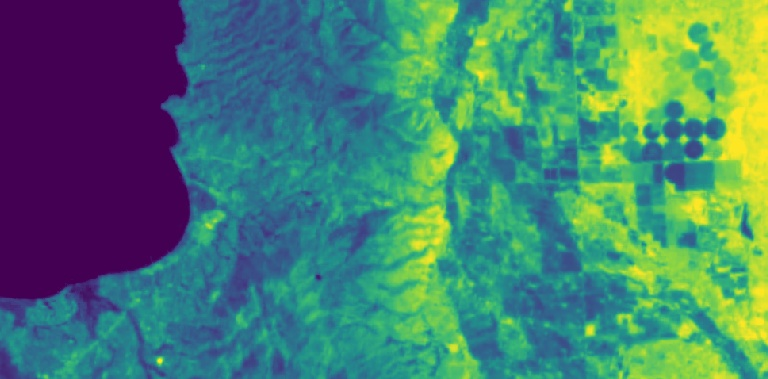

In [6]:
# Land surface temperature image
image_url = (
    landsat_img.select(['ST_B10']).multiply(0.00341802).add(149.0)
    .getThumbURL({'min': 295, 'max': 330, 'palette': viridis, 'dimensions':image_size, 'region': region})
)
Image(url=image_url, embed=True, format='png')

## Prepare the Landsat image for sharpening

This primarily consists of converting to reflectance and standardizing the band names.

In [7]:
# CGM - The "SPACECRAFT_ID" property must be set on the image for the algorithm to work
input_bands = ee.Dictionary({
    'LANDSAT_5': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'QA_PIXEL'],
    'LANDSAT_7': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'QA_PIXEL'],
    'LANDSAT_8': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL'],
    'LANDSAT_9': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL'],
})
output_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'lst', 'qa']
spacecraft_id = ee.String(landsat_img.get('SPACECRAFT_ID'))
prep_img = (
    landsat_img
    .select(input_bands.get(spacecraft_id), output_bands)
    .multiply([0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.00341802, 1])
    .add([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, 149.0, 1])
    .set({'system:index': landsat_img.get('system:index'),
          'system:time_start': landsat_img.get('system:time_start'),
          'system:id': landsat_img.get('system:id'), 
          'SPACECRAFT_ID': spacecraft_id,
         })
)

# image_url = (
#     prep_img.select(['lst'])
#     .getThumbURL({'min': 295, 'max': 330, 'palette': viridis, 'dimensions':image_size, 'region': region})
# )
# Image(url=image_url, embed=True, format='png')

## Run the thermal sharpening

https://earthengine.googleapis.com/v1/projects/openet/thumbnails/82ff90bc66ad608f0460215455658dd3-d4c846284405ac4c8673fcfdd32c4148:getPixels


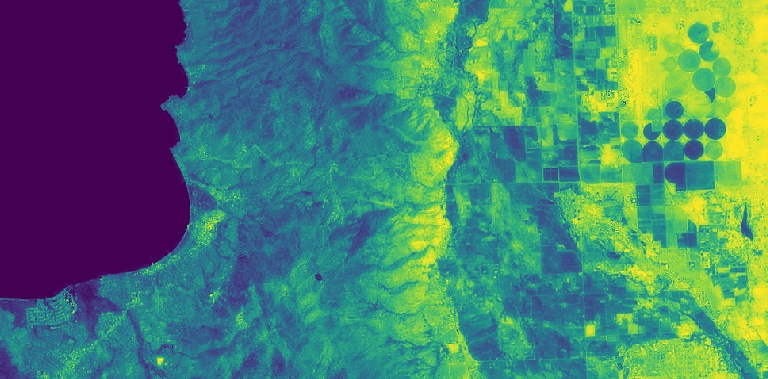

In [8]:
output_img = openet.lst.Model(prep_img).sharpen()

image_url = (
    output_img.select(['lst_sharpened'])
    .getThumbURL({'min': 295, 'max': 330, 'palette': viridis, 'dimensions':image_size, 'region': region})
)
print(image_url)
Image(url=image_url, embed=True, format='png')


In [9]:
# def point_image_value(image, xy, scale=1):
#     """Extract the output value from a calculation at a point"""
#     return ee.Image(image).reduceRegion(
#         reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
#         scale=scale).getInfo()

# pprint.pprint(point_image_value(prep_img.select(['tir']), site_xy, scale=1))
# pprint.pprint(point_image_value(output_img.select(['tir_sharpened']), site_xy, scale=1))
